In [1]:
import os
import random
import numpy as np

from dynamic_programming.policy_iteration import PolicyIteration
from dynamic_programming.mdp_model import MDPModel
from dynamic_programming.policy import DPPolicy
from envs.env_creator import env_creator
from base_rl.eval_policy import EvalDiscreteStatePolicy
from envs.plot import plot_industrial_benchmark_trajectories
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = [20, 12]
fixed_digits = 6


In [ ]:
# parameters

model_names = ['model_aeq-20bits3']
root_path = 'tmp'
steps_per_episode = 1000
training_episodes = [10, 100, 1000, 10000]

## Load Data and MDP Model

In [3]:
from experiments.offline_experiment_configs import OfflineDiscreteRLExperimentConfig


experiment_configs = []


for model_name in model_names:
    for i, training_episode in enumerate(training_episodes):
        experiment_configs.append(
            OfflineDiscreteRLExperimentConfig(
                model_name=model_name,
                model_path=os.path.join(root_path, 'state_quantization', model_name),
                dataset_path=os.path.join(root_path, "offline_rl_trajectories", model_name, "rl_dataset.npy"),
                mdp_path=os.path.join(root_path,'policy_iteration','mdp',model_name,f'{training_episode}','mdp_model.pkl'),
                policy_path=os.path.join(root_path,'policy_iteration',model_name, f'{training_episode}','policy.pkl'),
                dataset_size=training_episode*steps_per_episode)
        )
device = 'cpu'
reward_type = 'state'

In [4]:
from dynamic_programming.mdp_model import create_mdp_models


for config in experiment_configs:
    create_mdp_models(load_path=config.dataset_path, mdp_save_path=config.mdp_path, reward_function_type=reward_type, device=device, dataset_size=config.dataset_size)

tmp/policy_iteration/mdp/model_aeq-20bits3/10/mdp_model.pkl
-381.6059063415527
10000
1180
Computing Transition Model
Computing Reward Function
tmp/policy_iteration/mdp/model_aeq-20bits3/100/mdp_model.pkl
-349.6023522132111
100000
2426
Computing Transition Model
Computing Reward Function
tmp/policy_iteration/mdp/model_aeq-20bits3/1000/mdp_model.pkl
-344.6461636640358
1000000
3603
Computing Transition Model
Computing Reward Function
tmp/policy_iteration/mdp/model_aeq-20bits3/10000/mdp_model.pkl
-341.13575161187475
10000000
4691
Computing Transition Model
Computing Reward Function


## Train

0
1
# epoch: 3
eval count = [501, 51, 14]
policy change = [1137, 6, 0]


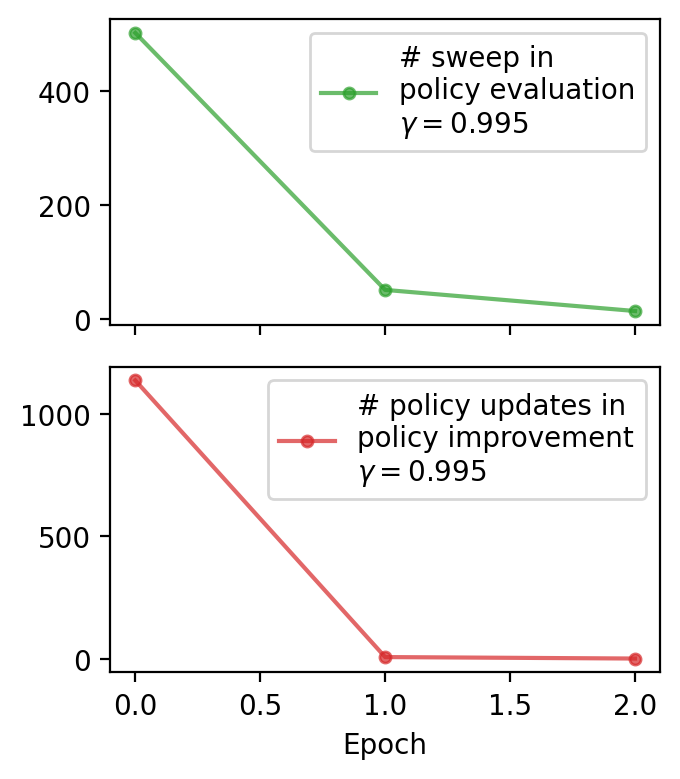

0
1
2
3
# epoch: 5
eval count = [501, 160, 58, 43, 25]
policy change = [2334, 223, 54, 10, 0]


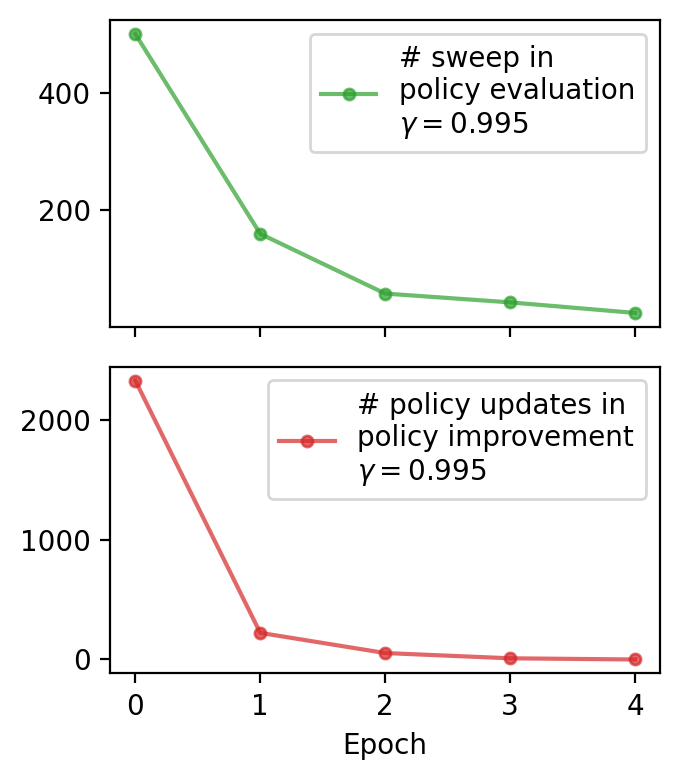

0
1
2
3
4
# epoch: 6
eval count = [501, 501, 112, 76, 97, 39]
policy change = [3452, 877, 383, 96, 11, 0]


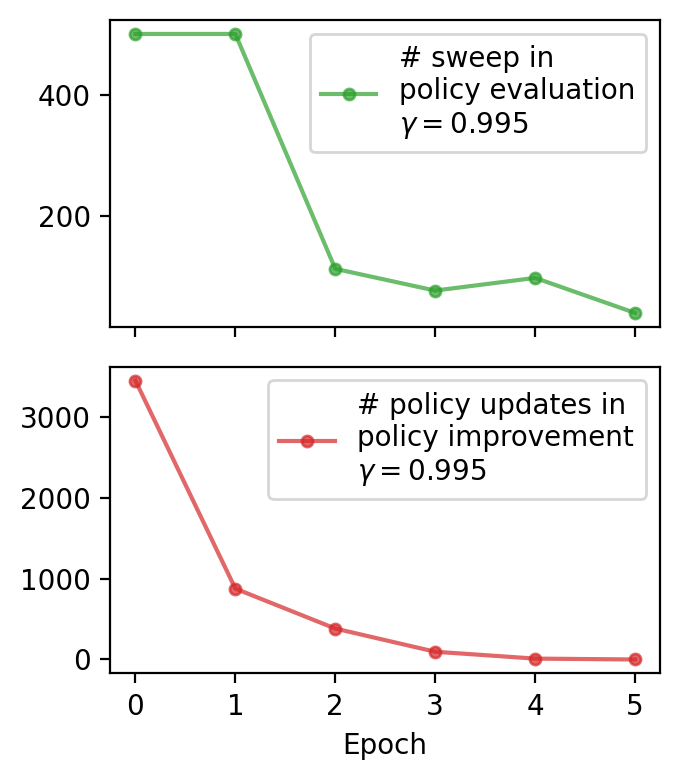

0
1
2
3
4
5
# epoch: 7
eval count = [501, 501, 299, 196, 166, 128, 59]
policy change = [4505, 1795, 1023, 422, 78, 6, 0]


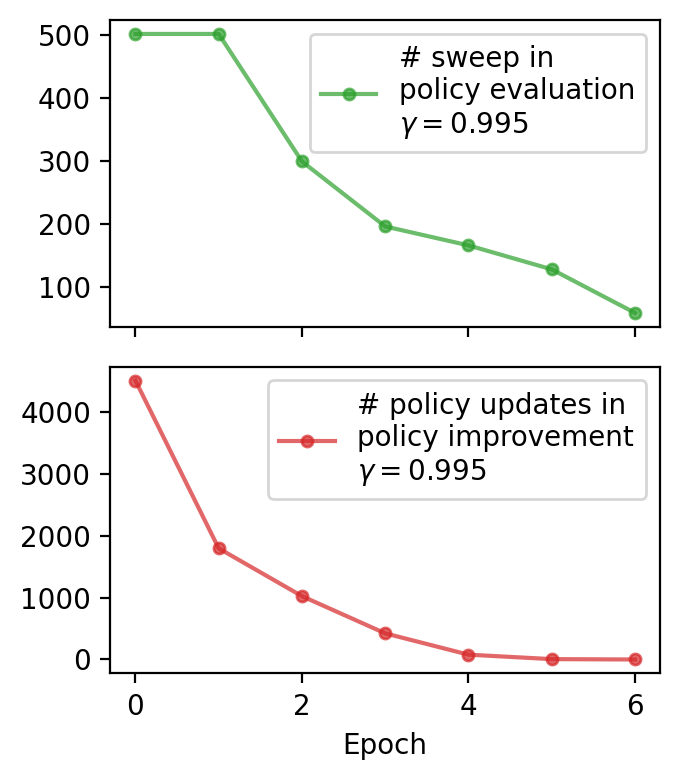

In [10]:
def train_policy_iteration(mdp_path, policy_save_path):
    mdp_model = MDPModel.load(mdp_path)
    solver = PolicyIteration(reward_function=mdp_model.reward_function, transition_model=mdp_model.transition_model,
                             gamma=0.995, sa_reward=reward_type)
    solver.train(total_epochs=10, eval_epochs=500)
    trained_policy = DPPolicy(policy_table=solver.policy, state_to_index=mdp_model.state_to_index,
                              index_to_action=mdp_model.index_to_actions)
    trained_policy.save(policy_save_path)


for config in experiment_configs:
    train_policy_iteration(mdp_path=config.mdp_path, policy_save_path=config.policy_path)

Tag: model_aeq-20bits3/10000000
Episode 9 Reward: -326.08886292676505 || New State Found: False


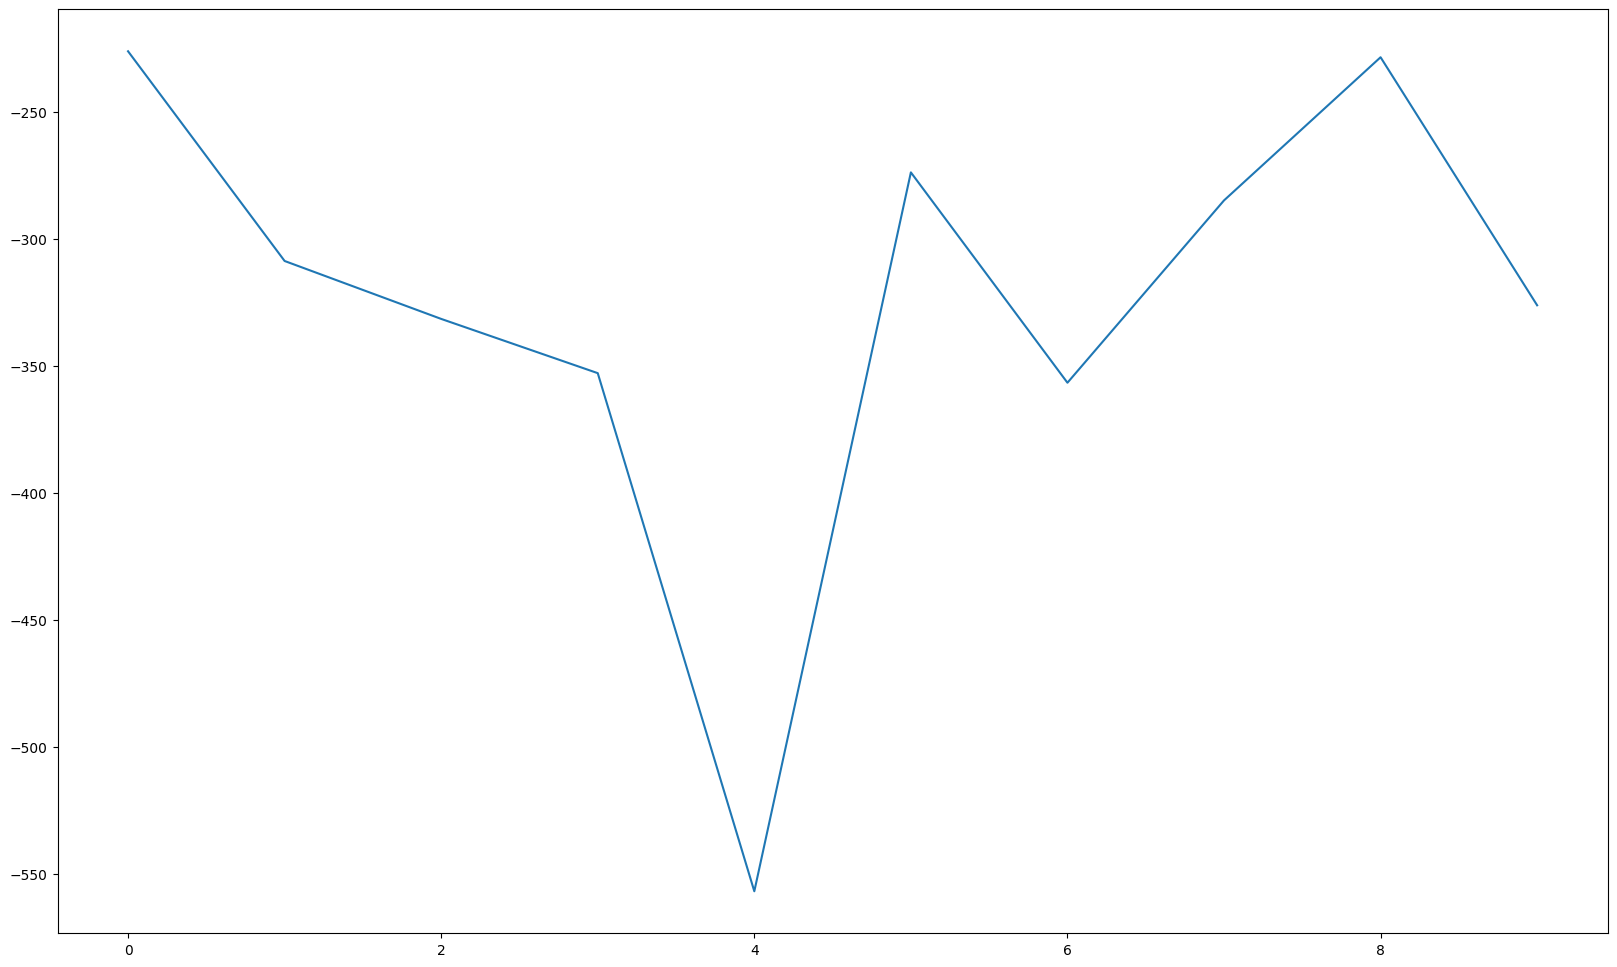

Reward Mean: -324.54463532996147
Reward std : 88.94794237616335


In [11]:
from benchmarks.policy_benchmarks import PolicyBenchmarks

steps_per_episode = 1000
evaluators = []
for config in experiment_configs:
    print(config.policy_path)
    eval_policy = config.get_saved_policy()
    env_kwargs = {'steps_per_episode': steps_per_episode, 'device': device, 'model_path': config.model_path}
    evaluator = EvalDiscreteStatePolicy(policy=eval_policy, env_creator=env_creator, env_kwargs=env_kwargs,
                                        tag=f'{config.model_name}/{config.dataset_size}')
    evaluators.append(evaluator)

policy_benchmarks = PolicyBenchmarks(evaluators=evaluators, epochs=10)
policy_benchmarks.benchmark()

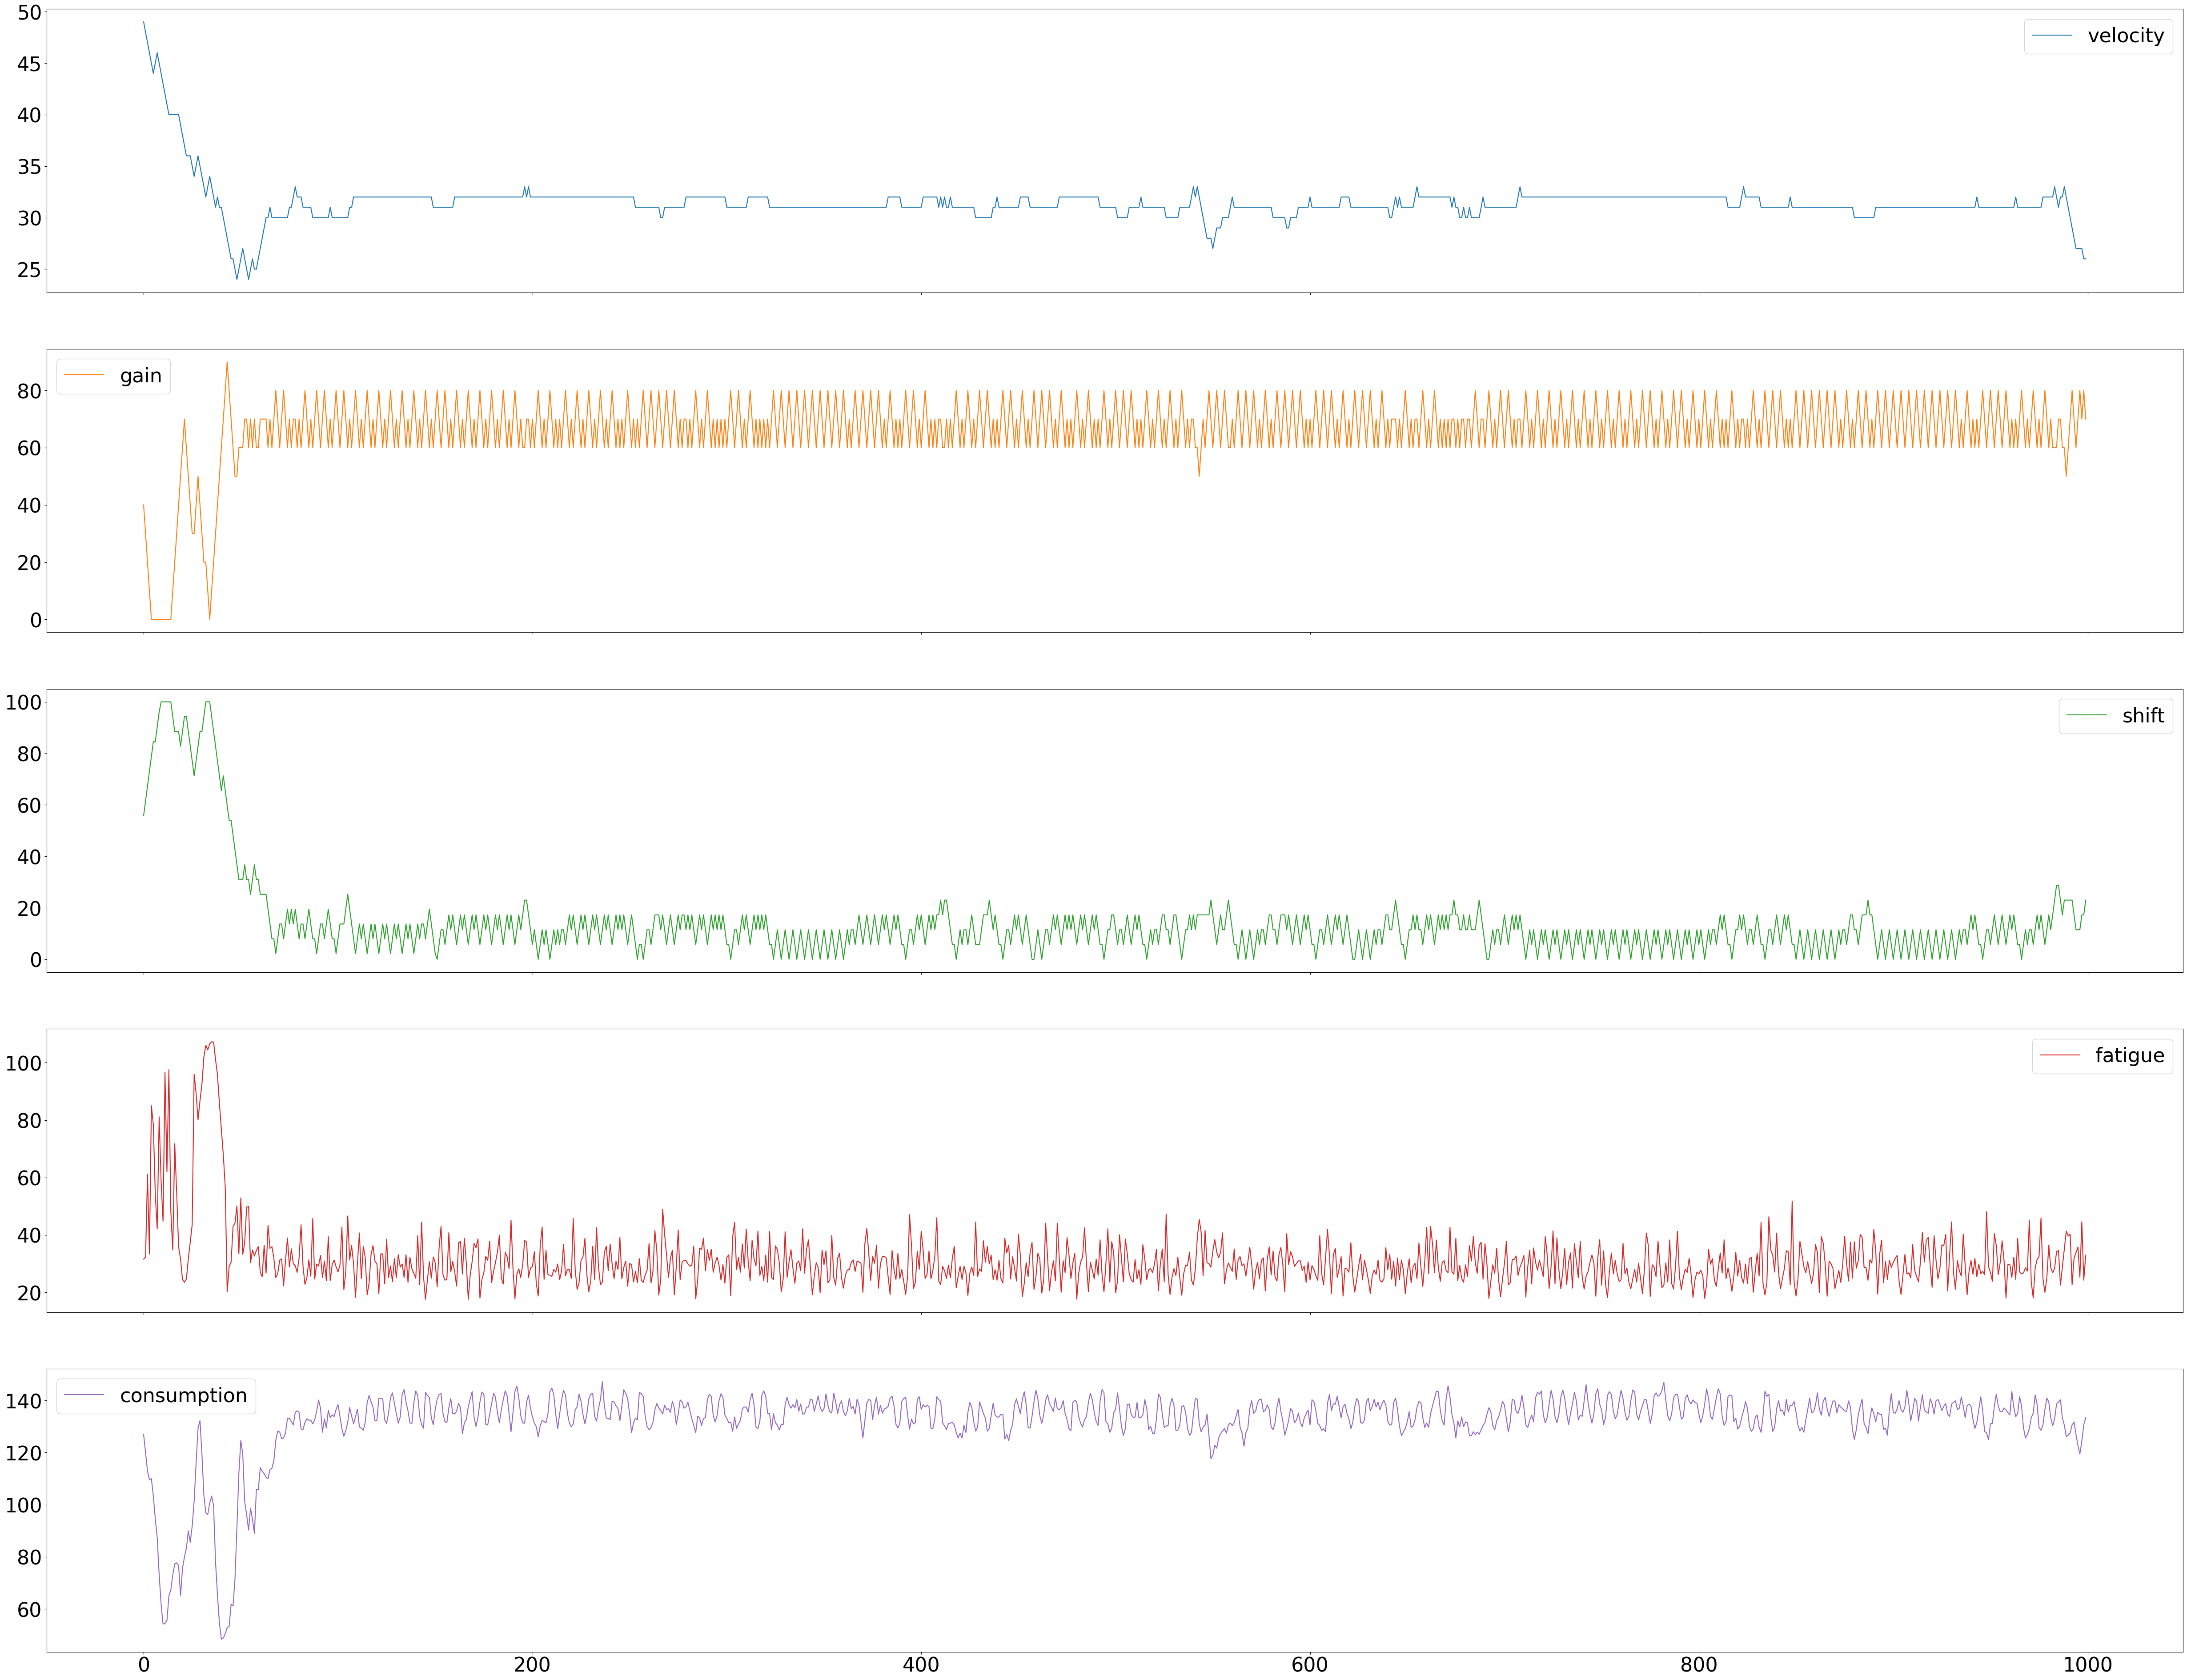

In [12]:
plot_industrial_benchmark_trajectories(policy_benchmarks.evaluators[-1].eval_trajectories[0]['info'])

In [13]:
df = pd.DataFrame(policy_benchmarks.benchmark_metrics)
df.T

,reward,std,unique_obs
model_aeq-20bits3/10000,-613.939554,42.188297,241.0
model_aeq-20bits3/100000,-797.961082,160.516423,272.0
model_aeq-20bits3/1000000,-275.254858,69.042151,813.0
model_aeq-20bits3/10000000,-324.544635,88.947942,720.0


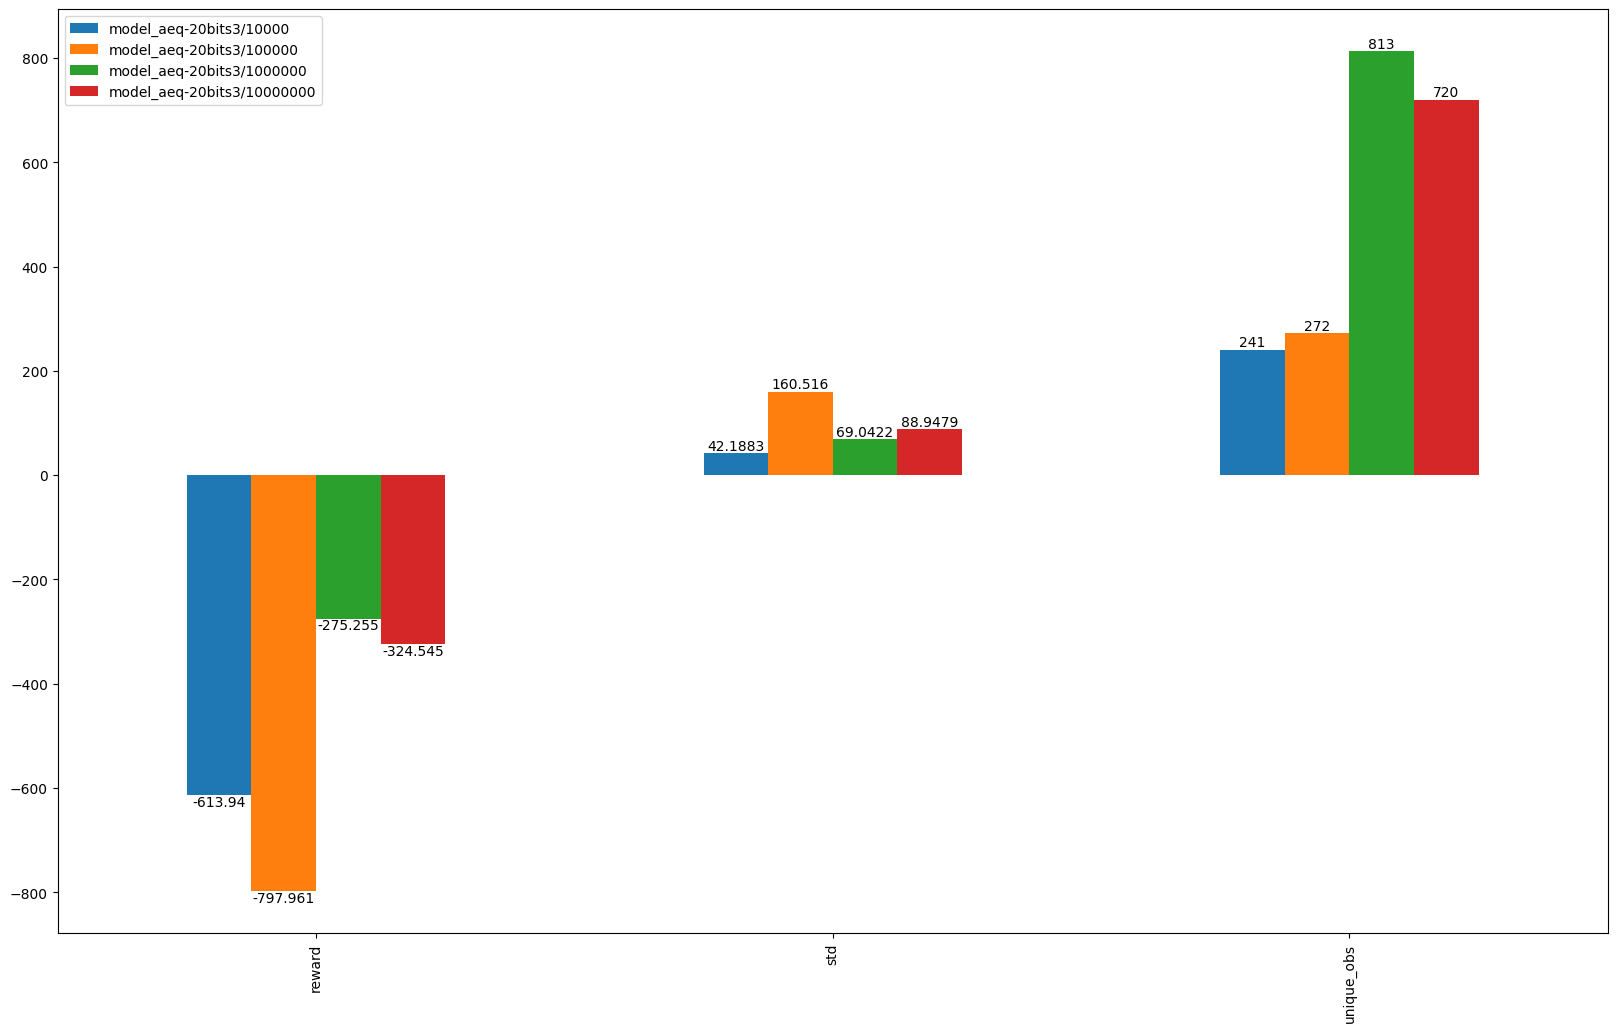

In [14]:

plt.rcParams["figure.figsize"] = [20, 12]


for model_name in model_names:
    m = np.core.defchararray.find(df.columns.values.astype(str), model_name) >= 0
    fdf = df.loc[:, m]
    ax = fdf.plot.bar()

    for container in ax.containers:
        ax.bar_label(container)
    plt.show()